<a href="https://colab.research.google.com/github/adalves-ufabc/2021.QS-PLN/blob/main/2021_Q1_PLN_Notebook_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2021.Q1]**
Prof. Alexandre Donizeti Alves

# **Análise de Sentimentos**

A **Análise de Sentimentos** é uma área do processamento de linguagem natural que visa sistematicamente extrair, quantificar, e estudar estados afetivos expressos em documentos. Existe diversas abordagens para se realizar análise de sentimento. Uma das mais usadas é a **Classificação de Sentimentos**.

### **Classificação de Sentimentos**

>
Na **Classificação de Sentimentos** usamos a classificação de documentos para classificar automaticamente se o sentimento expresso em um texto está associado a uma determinada emoção. Uma abordagem comum é tentar classificar documentos nas categorias `positivo` e `negativo`, cujo intuito é classificar se um determinado documento contém um sentimento positivo ou negativo. 


A **Classificação de Sentimentos** é muito usada em análise de redes sociais, para verificar a repercusão social a respeito de alguma entidade (por exemplo, um produto, serviço ou personalidade).

>
Vamos usar a matriz termo-documento e a classificação de documentos para gerar um Classificador de Sentimentos. Para fazer isso, vamos usar *tweets* de um corpus de análise de sentimentos diponibilizado pela biblioteca python `nlp`.

In [1]:
!pip install nlp

import nlp

# na primeira vez que executar, vai baixar o corpus
sentiment140 = nlp.load_dataset('sentiment140')

     |████████████████████████████████| 1.7MB 7.5MB/s 
     |████████████████████████████████| 245kB 35.2MB/s 


Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/2ad0bb6460a543b63240b86e18ec4b50cd40dd36f3d72ded82a9d695d34548d1. Subsequent calls will reuse this data.


Esse **corpus** já está dividido em um conjunto de `treino` e `teste`. Uma descrição do conteúdo do corpus pode ser vista [aqui](https://www.kaggle.com/kazanova/sentiment140), que também contém links para o artigo original.  O conjunto de teste tem **1.600.000** ***tweets*** no conjunto de `treino`, e 498 *tweets* no conjunto de `teste`:

In [ ]:
print(sentiment140['train'].num_rows)

1600000


In [ ]:
print(sentiment140['test'].num_rows)

498


Os autores do corpus usaram uma escala de 0 (negativo) a 4 (positivo) para designar o sentimento associado a cada *tweet*. No conjunto de `treino`, apenas essas duas classes estão presentes:

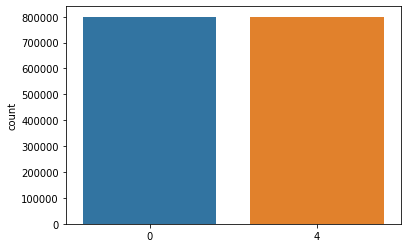

In [ ]:
import seaborn as sns

sns.countplot(x = sentiment140['train']['sentiment']);

O conjunto de `teste` também contém alguns *tweets* rotulados na classe 2 (neutro):

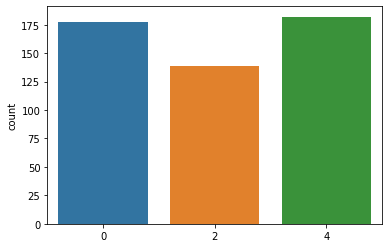

In [ ]:
sns.countplot(x = sentiment140['test']['sentiment']);

Como nas redes sociais as postagens geralmente usam uma linguagem informal, além de *emoticons* e *hashtags*, vamos usar um tokenizador que tenta fazer o parsing desses tipos de postagens. O pacote `nltk` tem um tokenizador especialmente desenvolvido, chamado de `TweetTokenizer`. 

In [2]:
from nltk.tokenize import TweetTokenizer

# preserve_case - mantem maiusculas
# reduce_len - remove algumas duplicações
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True)

Uma amostra desse método pode ser vista aplicando-se a um dos *tweets* da base:

In [3]:
print(sentiment140['train']['text'][0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [4]:
tknzr.tokenize(sentiment140['train']['text'][0])

['@switchfoot',
 'http://twitpic.com/2y1zl',
 '-',
 'awww',
 ',',
 "that's",
 'a',
 'bummer',
 '.',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 '.',
 ';D']

**Matriz termo-documento**

Na **matriz termo-documento** uma representação vetorial é usada  para representar um documento. Cada elemento está relacionao à frequência dos termos naqueles documentos. A similaridade entre documentos é calculada a partir da distância entre os vetores que representam os documentos. 

Vamos agora construir a **matriz termo-documento**. Inicialmente, vamos criar uma matriz com a frequência absoluta desses termos. Como temos o corpus com um grande número de *tweets*, para evitar crair uma matriz muito grande, mantemos somente os tokens que aparecem no mínimo em 30 *tweets*. Por questões de custo computacional vamos trabalhar com 10% da base.

In [ ]:
import random
random.seed(42)

# 10% da base
subset = random.sample(list(range(sentiment140['train'].num_rows)),k=int(0.1*sentiment140['train'].num_rows))

In [ ]:
train_tweets = [sentiment140['train'][i]['text'] for i in subset]
sentiment = [sentiment140['train'][i]['sentiment'] for i in subset]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# tokens que aparecem no minimo em 30 tweets
counter_vectorizer = CountVectorizer(tokenizer=tknzr.tokenize, stop_words='english', min_df=30)

counts = counter_vectorizer.fit_transform(train_tweets)

In [ ]:
counts

<160000x3874 sparse matrix of type '<class 'numpy.int64'>'
	with 1091918 stored elements in Compressed Sparse Row format>

Como resultado desse processamento, construímos uma matriz com 3874 termos e 160000 documentos (*tweets*).

Vamos agora repetir o processo, mas usando a representação TF-IDF:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=tknzr.tokenize, stop_words='english', min_df=30)

tfidf = tfidf_vectorizer.fit_transform(train_tweets)

In [ ]:
tfidf

<160000x3874 sparse matrix of type '<class 'numpy.float64'>'
	with 1091918 stored elements in Compressed Sparse Row format>

As dimensões da matriz são as mesmas, mas uma armazena a frequência absoluta dos termos, e a outra armazena o logaritmo da frequência ponderada pelo inverso da frequência no corpus inteiro. Podemos ter uma ideia da diferença entre as duas contagems criando um plot dos valores:

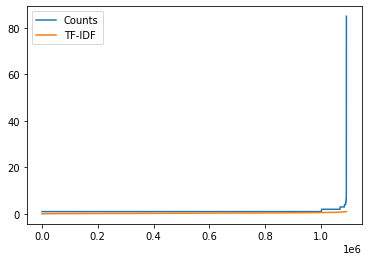

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sorted(counts.data),label="Counts");
plt.plot(sorted(tfidf.data),label="TF-IDF");
plt.legend();

Como pode ser observado no gráfico, para a contagem simples alguns termos muito frequentes têm valores maiores que 80 (o que pode ser considerado bem alto, considerando que um *tweet* tem 140 caracteres). Já a contagem TF-IDF tem valores menores, devido à ponderação logaritmica dos termos e o fator multiplicativo da frequência inversa em todos os documentos.

Vamos treinar um classificador para fazer a classificação automática dos *tweets*. Para isso, vamos usar o algoritmo de [Florestas Aleatórias](https://en.wikipedia.org/wiki/Random_forest), do pacote [scikit-learn](https://scikit-learn.org/stable/). 

> 
Floresta Aleatória (*Random Forest*) é um algoritmo de aprendizagem supervisionada. Como você pode perceber pelo seu nome, ele cria uma floresta de um modo aleatório. A "floresta" que ele cria é uma combinação de árvores de decisão, na maioria dos casos treinados com o método de *bagging*. A ideia principal do método de *bagging* é que a combinação dos modelos de aprendizado aumenta o resultado geral.
>
Dizendo de modo simples: o algoritmo de florestas aleatórias cria várias árvores de decisão e as combina para obter uma predição com maior acurácia e mais estável.

>**Mais informações em**: https://medium.com/machina-sapiens/o-algoritmo-da-floresta-aleat%C3%B3ria-3545f6babdf8

Inicialmente, vamos construir um classificador para a contagem de palavras:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_counts = RandomForestClassifier(n_estimators=100, random_state=42)
clf_counts.fit(counts, sentiment)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

E repetir o processo para a representação TF-IDF:

In [ ]:
clf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_tfidf.fit(tfidf, sentiment)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Uma das razões para usarmos o *Random Forest* nesse exemplo é que ele estima a importância de cada palavra (no jargão de aprendizado de máquina, as palavras na matriz termo-documento são conhecidas como *features*). Vamos analisar os 20 termos mais importantes para classificação de sentimento, de acordo com os modelos gerados.

In [ ]:
nwords = 20
counts_importance_idx = clf_counts.feature_importances_.argsort()[-nwords:]
tfidf_importance_idx = clf_tfidf.feature_importances_.argsort()[-nwords:]

O trecho a seguir faz um plot desses 20 termos, de acordo com a sua importância (estimada pelo modelos de classificação de sentimentos).

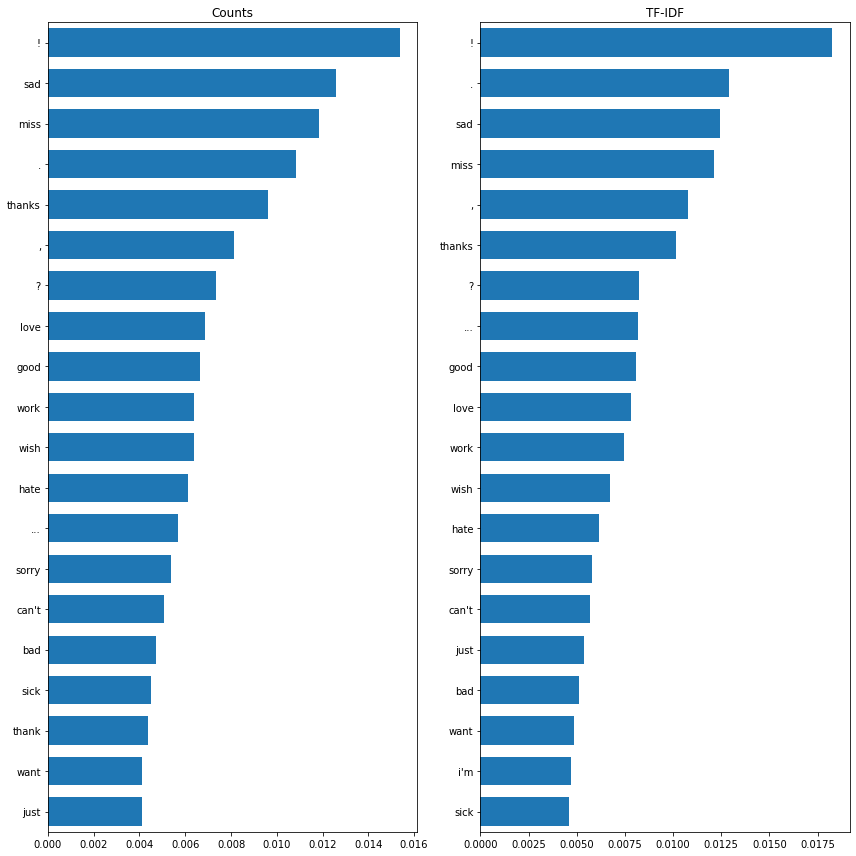

In [ ]:
import numpy as np

# variavel para ajustar os plots
tree_indices = np.arange(0, nwords) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.barh(tree_indices,
         clf_counts.feature_importances_[counts_importance_idx], height=0.7)
ax1.set_yticklabels(np.array(counter_vectorizer.get_feature_names())[counts_importance_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, nwords))
ax1.set_title("Counts")

ax2.barh(tree_indices,
         clf_tfidf.feature_importances_[tfidf_importance_idx], height=0.7)
ax2.set_yticklabels(np.array(tfidf_vectorizer.get_feature_names())[tfidf_importance_idx])
ax2.set_yticks(tree_indices)
ax2.set_ylim((0, nwords))
ax2.set_title("TF-IDF")

fig.tight_layout()
plt.show()

Observe que ambos modelos compartilham diversos termos entre os mais importantes, apesar de que em vários deles a ordem é diferente. Entretando, há alguns termos que só aparecem para alguns modelos, como podemos ver a seguir:

In [ ]:
counts_importance_terms = set(np.array(counter_vectorizer.get_feature_names())[counts_importance_idx])
tfidf_importance_terms = set(np.array(tfidf_vectorizer.get_feature_names())[tfidf_importance_idx])

Palavras que só aparecem no modelo gerado a partir da contagem:

In [ ]:
counts_importance_terms - tfidf_importance_terms

{'thank'}

Palavras que só aparecem no modelo gerado a partir da representação TF-IDF:

In [ ]:
tfidf_importance_terms - counts_importance_terms

{"i'm"}

Vamos avaliar o desempenho desses modelos. Inicialmente, vamos usar o conjunto de `teste`. Como o conjunto de `teste` tem uma classe que não estava presente no conjunto de treino (a classe neutra), os modelos não irão classificar corretamente os *tweets* dessa classe.  Vamos analisar a [matriz de confusão](https://en.wikipedia.org/wiki/Confusion_matrix) e o relatório de classificação gerado pelo `scikit-learn`:

Vamos inicialmente analisar a contagem simples. Para facilitar o processo, o `scikit-learn` permite a criação de um pipeline, que aplica o processamento de texto e o modelo em sequência:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, classification_report

pipeline_counts = Pipeline([
    ('vect', counter_vectorizer),
    ('clf', clf_counts)
])

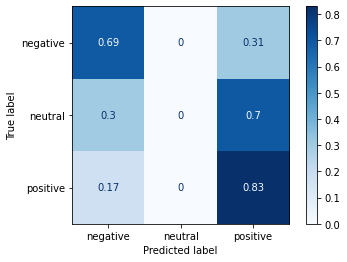

In [ ]:
plot_confusion_matrix(pipeline_counts, sentiment140['test']['text'], sentiment140['test']['sentiment'],
                                 display_labels=['negative','neutral','positive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true');

In [ ]:
print(classification_report(sentiment140['test']['sentiment'], pipeline_counts.predict(sentiment140['test']['text']),zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       177
           2       0.00      0.00      0.00       139
           4       0.50      0.83      0.62       182

    accuracy                           0.55       498
   macro avg       0.38      0.51      0.43       498
weighted avg       0.41      0.55      0.46       498



Podemos repetir o processo para o TF-IDF:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       177
           2       0.00      0.00      0.00       139
           4       0.47      0.83      0.60       182

    accuracy                           0.53       498
   macro avg       0.37      0.49      0.41       498
weighted avg       0.40      0.53      0.44       498



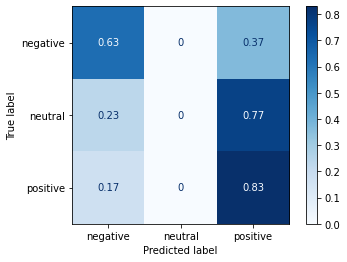

In [ ]:
pipeline_tfidf = Pipeline([
    ('vect', tfidf_vectorizer),
    ('clf', clf_tfidf)
])

plot_confusion_matrix(pipeline_tfidf, sentiment140['test']['text'], sentiment140['test']['sentiment'],
                                 display_labels=['negative','neutral','positive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

print(classification_report(sentiment140['test']['sentiment'], pipeline_tfidf.predict(sentiment140['test']['text']),zero_division=0))

Analisando os resultados, podemos ver que no conjunto de `teste`, há uma tendência um pouco maior do classificador gerado a partir do processamento TF-IDF a predizer a classe positiva. 

Para essa base em particular, o conjunte de `teste` é relativamente pequeno. Como usamos apenas 10% dos *tweets* do conjunto de treino para gerar o modelo, há vários *tweets* que não foram usados nesta etapa. Podemos usar exemplos desse conjunto para fazer uma avaliação com mais dados. No trecho de código a seguir, são gerados 10 conjuntos aleatórios com 10% dos *tweets*. A acurácia do modelo é avaliada para cada um desses conjuntos, e finalmente calculamos a **média** e **desvio padrão** para essas 10 execuções:

In [ ]:
from sklearn.metrics import accuracy_score

accuracies_count = []
accuracies_tfidf = []

for i in range(10):
    random.seed(i)
    subset = random.sample(list(range(sentiment140['train'].num_rows)),k=int(0.1*sentiment140['train'].num_rows))
    
    val_tweets = [sentiment140['train'][i]['text'] for i in subset]
    sentiment = [sentiment140['train'][i]['sentiment'] for i in subset]
    
    accuracies_count.append(accuracy_score(sentiment,pipeline_counts.predict(val_tweets)))
    accuracies_tfidf.append(accuracy_score(sentiment,pipeline_tfidf.predict(val_tweets)))

In [ ]:
print("Acurárcia média para a contagem simples: {0:.2f} ({1:.2f})".format(
    np.mean(accuracies_count)*100, np.std(accuracies_count)*100))

print("Acurárcia média para a contagem tf-idf: {0:.2f} ({1:.2f})".format(
    np.mean(accuracies_tfidf)*100, np.std(accuracies_tfidf)*100))


Acurárcia média para a contagem simples: 76.30 (0.08)
Acurárcia média para a contagem tf-idf: 76.66 (0.08)


Como pode ser observado, há uma pequena melhora com a abordagem TF-IDF quando avaliamos com o conjunto maior. Entretanto, os resultados são bastante parecidos. Isso acontece pois, em textos curtos, a ponderação IDF (que leva em consideração o log) tem pouco efeito. Mas em muitas aplicações, há algum ganho usando-se TF-IDF em comparação com a contagem simples.

**Referência**:

Este notebook foi criado pelo prof. **Ronaldo Prati** [UFABC], tendo sido apenas reestruturado por mim.